# 2. Data Preprocessing and Model Training - Bicep Curl

**Objective:**
1. Load raw landmark data.
2. Extract arm features (elbow angle, shoulder angle) using `GeometryUtils`.
3. Preprocess features (scaling).
4. Train multiple classification models for left and right arms separately.
5. Evaluate and compare model performance.
6. Save the scalers, all trained models, and a selected best model (e.g., RandomForest) in `.pkl` format.

In [ ]:
import pandas as pd
import numpy as np
import pickle
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns

module_path = os.path.abspath(os.path.join('../../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from utils.geometry_utils import GeometryUtils

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_score, recall_score, f1_score

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV

import warnings
warnings.filterwarnings('ignore')

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 5)
plt.rcParams['font.size'] = 10

## 2.1 Define Paths and Constants

In [31]:
BASE_DATA_PATH = "../data/"
TRAIN_RAW_PATH = os.path.join(BASE_DATA_PATH, "train.csv")
TEST_RAW_PATH = os.path.join(BASE_DATA_PATH, "test.csv")

MODEL_PKL_DIR = "../models/pkl/"
os.makedirs(MODEL_PKL_DIR, exist_ok=True)

VISIBILITY_THRESHOLD = 0.5

## 2.2 Feature Extraction Function

In [32]:
def extract_arm_features_from_df(df_raw, geometry_util):
    """Processes a raw DataFrame and extracts arm features using GeometryUtils."""
    processed_data_left = []
    processed_data_right = []

    for index, row in df_raw.iterrows():
        label_original = row["label"]
        
        if label_original == "C":
            label_numeric = 1
        elif label_original == "L": 
            label_numeric = 0
        else:
            print(f"Warning: Unknown label '{label_original}' at index {index}. Skipping.")
            continue 
            
        # Left Arm Landmarks
        sh_l_x, sh_l_y, sh_l_v = row.get("left_shoulder_x", np.nan), row.get("left_shoulder_y", np.nan), row.get("left_shoulder_v", 0)
        el_l_x, el_l_y, el_l_v = row.get("left_elbow_x", np.nan), row.get("left_elbow_y", np.nan), row.get("left_elbow_v", 0)
        wr_l_x, wr_l_y, wr_l_v = row.get("left_wrist_x", np.nan), row.get("left_wrist_y", np.nan), row.get("left_wrist_v", 0)
        hip_l_x, hip_l_y, hip_l_v = row.get("left_hip_x", np.nan), row.get("left_hip_y", np.nan), row.get("left_hip_v", 0)

        # Right Arm Landmarks
        sh_r_x, sh_r_y, sh_r_v = row.get("right_shoulder_x", np.nan), row.get("right_shoulder_y", np.nan), row.get("right_shoulder_v", 0)
        el_r_x, el_r_y, el_r_v = row.get("right_elbow_x", np.nan), row.get("right_elbow_y", np.nan), row.get("right_elbow_v", 0)
        wr_r_x, wr_r_y, wr_r_v = row.get("right_wrist_x", np.nan), row.get("right_wrist_y", np.nan), row.get("right_wrist_v", 0)
        hip_r_x, hip_r_y, hip_r_v = row.get("right_hip_x", np.nan), row.get("right_hip_y", np.nan), row.get("right_hip_v", 0)

        # Process Left Arm
        if all(v > VISIBILITY_THRESHOLD for v in [sh_l_v, el_l_v, wr_l_v, hip_l_v]):
            if not any(np.isnan([sh_l_x, sh_l_y, el_l_x, el_l_y, wr_l_x, wr_l_y, hip_l_x, hip_l_y])):
                left_shoulder = [sh_l_x, sh_l_y]
                left_elbow = [el_l_x, el_l_y]
                left_wrist = [wr_l_x, wr_l_y]
                left_hip = [hip_l_x, hip_l_y]
                
                left_elbow_angle = geometry_util.calculate_angle(left_shoulder, left_elbow, left_wrist)
                left_shoulder_angle = geometry_util.calculate_angle(left_elbow, left_shoulder, left_hip)
                
                if not (np.isnan(left_elbow_angle) or np.isnan(left_shoulder_angle)):
                    processed_data_left.append({
                        "label": label_numeric,
                        "elbow_angle": left_elbow_angle,
                        "shoulder_angle": left_shoulder_angle
                    })
            
        # Process Right Arm
        if all(v > VISIBILITY_THRESHOLD for v in [sh_r_v, el_r_v, wr_r_v, hip_r_v]):
            if not any(np.isnan([sh_r_x, sh_r_y, el_r_x, el_r_y, wr_r_x, wr_r_y, hip_r_x, hip_r_y])):
                right_shoulder = [sh_r_x, sh_r_y]
                right_elbow = [el_r_x, el_r_y]
                right_wrist = [wr_r_x, wr_r_y]
                right_hip = [hip_r_x, hip_r_y]

                right_elbow_angle = geometry_util.calculate_angle(right_shoulder, right_elbow, right_wrist)
                right_shoulder_angle = geometry_util.calculate_angle(right_elbow, right_shoulder, right_hip)
                
                if not (np.isnan(right_elbow_angle) or np.isnan(right_shoulder_angle)):
                    processed_data_right.append({
                        "label": label_numeric,
                        "elbow_angle": right_elbow_angle,
                        "shoulder_angle": right_shoulder_angle
                    })

    df_left = pd.DataFrame(processed_data_left)
    df_right = pd.DataFrame(processed_data_right)
    return df_left, df_right

## 2.3 Load and Process Data

In [33]:
try:
    df_raw_train = pd.read_csv(TRAIN_RAW_PATH)
    df_raw_test = pd.read_csv(TEST_RAW_PATH)
    print(f"Raw train data shape: {df_raw_train.shape}")
    print(f"Raw test data shape: {df_raw_test.shape}")
except FileNotFoundError as e:
    print(f"Error loading data: {e}. Please ensure CSV files are in '{BASE_DATA_PATH}'.")
    df_raw_train, df_raw_test = pd.DataFrame(), pd.DataFrame() # Avoid further errors

geo_utils = GeometryUtils()

if not df_raw_train.empty and not df_raw_test.empty:
    print("\nProcessing training data...")
    df_left_train, df_right_train = extract_arm_features_from_df(df_raw_train, geo_utils)
    print("Processing testing data...")
    df_left_test, df_right_test = extract_arm_features_from_df(df_raw_test, geo_utils)

    print(f"\n--- Left Arm Data ---")
    print(f"Train shape: {df_left_train.shape}, Test shape: {df_left_test.shape}")
    if not df_left_train.empty: print(f"Train label distribution:\n{df_left_train['label'].value_counts(normalize=True)}")
    if not df_left_test.empty: print(f"Test label distribution:\n{df_left_test['label'].value_counts(normalize=True)}")

    print(f"\n--- Right Arm Data ---")
    print(f"Train shape: {df_right_train.shape}, Test shape: {df_right_test.shape}")
    if not df_right_train.empty: print(f"Train label distribution:\n{df_right_train['label'].value_counts(normalize=True)}")
    if not df_right_test.empty: print(f"Test label distribution:\n{df_right_test['label'].value_counts(normalize=True)}")
else:
    print("Raw data not loaded. Skipping feature extraction.")
    # Create empty DFs to prevent errors in subsequent cells if execution continues
    df_left_train, df_right_train = pd.DataFrame(), pd.DataFrame()
    df_left_test, df_right_test = pd.DataFrame(), pd.DataFrame()

Raw train data shape: (15372, 37)
Raw test data shape: (604, 37)

Processing training data...
Processing testing data...

--- Left Arm Data ---
Train shape: (10557, 3), Test shape: (285, 3)
Train label distribution:
label
1    0.536137
0    0.463863
Name: proportion, dtype: float64
Test label distribution:
label
1    0.536842
0    0.463158
Name: proportion, dtype: float64

--- Right Arm Data ---
Train shape: (11222, 3), Test shape: (319, 3)
Train label distribution:
label
1    0.533862
0    0.466138
Name: proportion, dtype: float64
Test label distribution:
label
1    0.583072
0    0.416928
Name: proportion, dtype: float64
Processing testing data...

--- Left Arm Data ---
Train shape: (10557, 3), Test shape: (285, 3)
Train label distribution:
label
1    0.536137
0    0.463863
Name: proportion, dtype: float64
Test label distribution:
label
1    0.536842
0    0.463158
Name: proportion, dtype: float64

--- Right Arm Data ---
Train shape: (11222, 3), Test shape: (319, 3)
Train label distrib

## 2.4 Model Training and Evaluation Function

In [ ]:
def _train_and_evaluate_sklearn_models(X_train_scaled, y_train, X_test_scaled, y_test, algorithms, arm_name):
    """Trains and evaluates a list of sklearn models."""
    trained_models = {}
    evaluation_results = []

    for name, model_instance in algorithms:
        print(f"\n--- Training {name} for {arm_name} Arm ---")
        
        if name == 'RF': # Special handling for RandomForest with GridSearchCV
            param_grid_rf = {
                'n_estimators': [50, 100],
                'max_depth': [10, None],
                'min_samples_split': [2, 5]
            }
            grid_search = GridSearchCV(estimator=model_instance, param_grid=param_grid_rf, cv=3, n_jobs=-1, verbose=0, scoring='f1_weighted')
            grid_search.fit(X_train_scaled, y_train)
            best_model = grid_search.best_estimator_
            print(f"Best RF params: {grid_search.best_params_}")
            trained_model = best_model
        else:
            # For other models, fit directly
            model_instance.fit(X_train_scaled, y_train)
            trained_model = model_instance
            
        trained_models[name] = trained_model

        # Evaluate on Training Data
        y_pred_train_model = trained_model.predict(X_train_scaled)
        train_accuracy = accuracy_score(y_train, y_pred_train_model)
        print(f"{name} - Training Accuracy: {train_accuracy:.4f}")

        # Evaluate on Test Data
        if not X_test_scaled.empty and y_test.size > 0 :
            y_pred_test_model = trained_model.predict(X_test_scaled)
            p_score = precision_score(y_test, y_pred_test_model, average='weighted', zero_division=0)
            a_score = accuracy_score(y_test, y_pred_test_model)
            r_score = recall_score(y_test, y_pred_test_model, average='weighted', zero_division=0)
            f1_val = f1_score(y_test, y_pred_test_model, average='weighted', zero_division=0)
            cm = confusion_matrix(y_test, y_pred_test_model, labels=[0, 1])
            evaluation_results.append((name, f"{p_score:.3f}", f"{a_score:.3f}", f"{r_score:.3f}", f"{f1_val:.3f}", cm))
            print(f"{name} - Test Accuracy: {a_score:.4f}")
            print(f"{name} - Test F1-Score (Weighted): {f1_val:.4f}")
        else:
            evaluation_results.append((name, "N/A", "N/A", "N/A", "N/A", np.array([[0,0],[0,0]])))
            print(f"{name} - Test set empty or resulted in no scorable data, skipping test evaluation.")

    results_df = pd.DataFrame()
    if evaluation_results:
        results_df = pd.DataFrame(evaluation_results, columns=["Model", "Precision (W)", "Accuracy", "Recall (W)", "F1-Score (W)", "Confusion Matrix"])
        results_df['F1-Score (Numeric)'] = pd.to_numeric(results_df['F1-Score (W)'], errors='coerce')
        results_df = results_df.sort_values(by='F1-Score (Numeric)', ascending=False).drop(columns=['F1-Score (Numeric)'])
        print(f"\n--- Evaluation Summary for {arm_name} Arm (Sorted by F1-Score) ---")
        display(results_df)
        
        # Plot F1 Scores
        plt.figure(figsize=(12, 6))
        plot_df = results_df[results_df['F1-Score (W)'] != 'N/A'].copy()
        if not plot_df.empty:
            plot_df['F1-Score (W)'] = plot_df['F1-Score (W)'].astype(float)
            sns.barplot(x='F1-Score (W)', y='Model', data=plot_df.sort_values(by='F1-Score (W)', ascending=False), palette='viridis')
            plt.title(f'Model F1-Scores (Weighted) for {arm_name} Arm')
            plt.xlabel('F1-Score (Weighted)')
            plt.ylabel('Model')
            plt.xlim(0, 1)
            plt.tight_layout()
            plt.show()

        # Plot Confusion Matrix for the best model
        if not results_df.empty:
            best_model_name = results_df.iloc[0]['Model']
            best_cm = results_df.iloc[0]['Confusion Matrix']
            if isinstance(best_cm, np.ndarray) and best_cm.shape == (2,2) and results_df.iloc[0]['F1-Score (W)'] != 'N/A':
                 plt.figure(figsize=(6, 5))
                 sns.heatmap(best_cm, annot=True, fmt='d', cmap='Blues', 
                             xticklabels=["L (Incorrect)", "C (Correct)"], 
                             yticklabels=["L (Incorrect)", "C (Correct)"])
                 plt.title(f'Confusion Matrix for Best Model ({best_model_name}) - {arm_name} Arm')
                 plt.xlabel('Predicted Label')
                 plt.ylabel('True Label')
                 plt.show()
            elif results_df.iloc[0]['F1-Score (W)'] == 'N/A':
                 print(f"Best model ({best_model_name}) had no test evaluation, skipping confusion matrix.")
            else:
                 print(f"Confusion matrix for {best_model_name} is not in the expected 2x2 format or had issues. Shape: {best_cm.shape if isinstance(best_cm, np.ndarray) else 'N/A'}")
    else:
        print("No evaluation results to display.")
        
    return trained_models, results_df

def _save_model_artifacts(scaler, trained_models, arm_name, model_pkl_dir):
    """Saves scaler and all trained models dictionary."""
    if scaler:
        scaler_filename = os.path.join(model_pkl_dir, f"scaler_{arm_name.lower()}.pkl")
        with open(scaler_filename, "wb") as f:
            pickle.dump(scaler, f)
        print(f"Scaler saved to {scaler_filename}")

    if trained_models:
        all_models_filename = os.path.join(model_pkl_dir, f"all_sklearn_models_{arm_name.lower()}.pkl")
        with open(all_models_filename, "wb") as f:
            pickle.dump(trained_models, f)
        print(f"All trained models dictionary saved to {all_models_filename}")
    else:
        print(f"No trained models provided for {arm_name} arm. Skipping saving of all_sklearn_models dictionary.")

def save_chosen_model(model_to_save, model_key, arm_name, model_pkl_dir):
    """Saves a single chosen model to a .pkl file."""
    if model_to_save is not None and model_key:
        model_filename = os.path.join(model_pkl_dir, f"{model_key}_model_{arm_name.lower()}.pkl")
        with open(model_filename, "wb") as f:
            pickle.dump(model_to_save, f)
        print(f"Chosen model '{model_key}' for {arm_name} arm saved to {model_filename}")
    else:
        print(f"No model or model key provided for {arm_name} arm. Skipping saving of chosen model.")

def train_and_evaluate_all_models(df_train, df_test, arm_name):
    """Orchestrates training and evaluation of models, returns scaler, models, and results."""
    print(f"\n{'='*20} Processing for {arm_name} Arm {'='*20}")

    if df_train.empty or len(df_train['label'].unique()) < 2:
        print(f"Not enough data or classes to train {arm_name} arm model (found {len(df_train)} rows, {df_train['label'].nunique()} unique labels). Skipping.")
        return None, None, None
    if df_test.empty:
        print(f"Warning: Test set for {arm_name} arm is empty. Evaluation on test set will be skipped.")
    
    X_train = df_train.drop("label", axis=1)
    y_train = df_train["label"]
    
    X_test, y_test = pd.DataFrame(), pd.Series(dtype='int')
    if not df_test.empty:
        X_test = df_test.drop("label", axis=1)
        y_test = df_test["label"]

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = pd.DataFrame() 
    if not X_test.empty:
        X_test_scaled = scaler.transform(X_test)
        X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

    algorithms = [
        ("LR", LogisticRegression(random_state=42, solver='liblinear', class_weight='balanced')),
        ("SVC", SVC(probability=True, random_state=42, class_weight='balanced')),
        ('KNN', KNeighborsClassifier(n_neighbors=5)),
        ("DTC", DecisionTreeClassifier(random_state=42, class_weight='balanced')),
        ("SGDC", CalibratedClassifierCV(SGDClassifier(random_state=42, class_weight='balanced', loss='hinge'))),
        ("NB", GaussianNB()),
        ('RF', RandomForestClassifier(random_state=42, class_weight='balanced', n_jobs=-1))
    ]

    trained_models, results_df = _train_and_evaluate_sklearn_models(
        X_train_scaled, y_train, X_test_scaled, y_test, algorithms, arm_name
    )
            
    return scaler, trained_models, results_df

## 2.5 Train Models for Left and Right Arms


==================== Processing for Left Arm ====================

--- Training LR for Left Arm ---
LR - Training Accuracy: 0.6952
LR - Test Accuracy: 0.8105
LR - Test F1-Score (Weighted): 0.8063

--- Training SVC for Left Arm ---
SVC - Training Accuracy: 0.7720
SVC - Test Accuracy: 0.7509
SVC - Test F1-Score (Weighted): 0.7458

--- Training KNN for Left Arm ---
SVC - Training Accuracy: 0.7720
SVC - Test Accuracy: 0.7509
SVC - Test F1-Score (Weighted): 0.7458

--- Training KNN for Left Arm ---
KNN - Training Accuracy: 0.8733
KNN - Test Accuracy: 0.6140
KNN - Test F1-Score (Weighted): 0.6125

--- Training DTC for Left Arm ---
DTC - Training Accuracy: 1.0000
DTC - Test Accuracy: 0.6000
DTC - Test F1-Score (Weighted): 0.5976

--- Training SGDC for Left Arm ---
SGDC - Training Accuracy: 0.7327
SGDC - Test Accuracy: 0.8526
SGDC - Test F1-Score (Weighted): 0.8510

--- Training NB for Left Arm ---
NB - Training Accuracy: 0.6755
KNN - Training Accuracy: 0.8733
KNN - Test Accuracy: 0.6140
KNN 

,Model,Precision (W),Accuracy,Recall (W),F1-Score (W),Confusion Matrix
5,NB,0.893,0.867,0.867,0.866,"[[131, 1], [37, 116]]"
4,SGDC,0.888,0.853,0.853,0.851,"[[132, 0], [42, 111]]"
0,LR,0.866,0.811,0.811,0.806,"[[132, 0], [54, 99]]"
1,SVC,0.759,0.751,0.751,0.746,"[[81, 51], [20, 133]]"
6,RF,0.638,0.639,0.639,0.635,"[[70, 62], [41, 112]]"
2,KNN,0.613,0.614,0.614,0.613,"[[72, 60], [50, 103]]"
3,DTC,0.598,0.600,0.600,0.598,"[[68, 64], [50, 103]]"


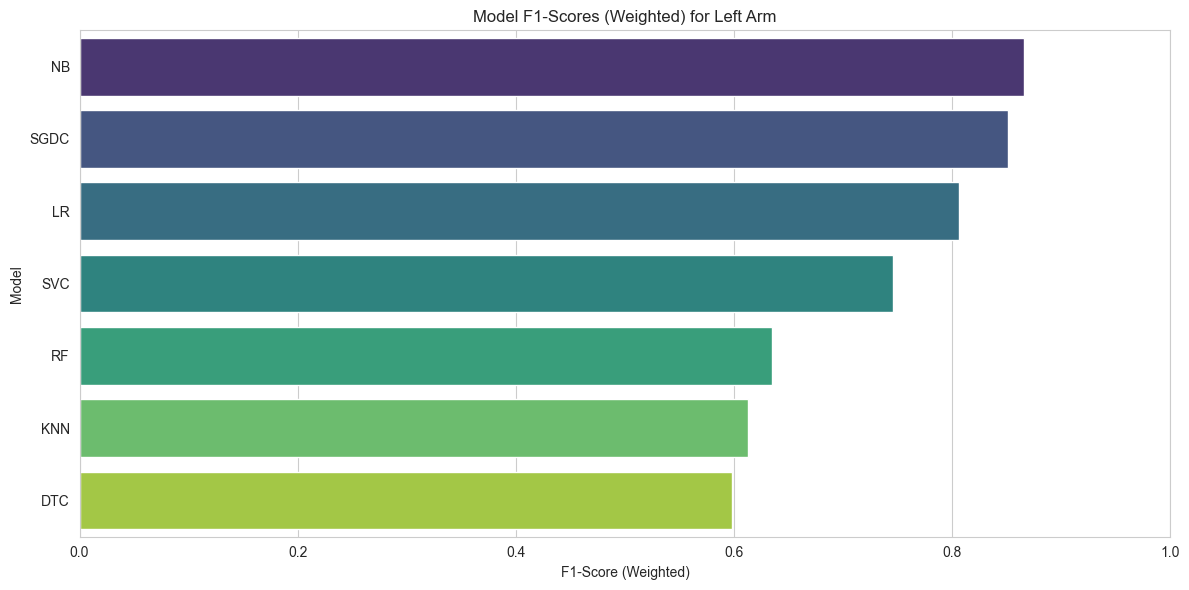

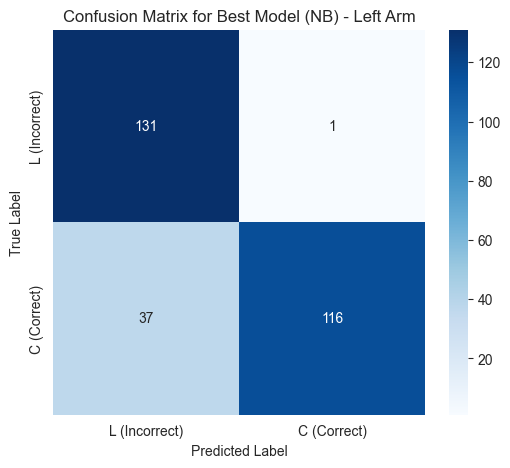

Scaler saved to ../models/pkl/scaler_left.pkl
All trained models dictionary saved to ../models/pkl/all_sklearn_models_left.pkl

==================== Processing for Right Arm ====================

--- Training LR for Right Arm ---
LR - Training Accuracy: 0.7099
LR - Test Accuracy: 0.7962
LR - Test F1-Score (Weighted): 0.7955

--- Training SVC for Right Arm ---
SVC - Training Accuracy: 0.7963
SVC - Test Accuracy: 0.8903
SVC - Test F1-Score (Weighted): 0.8910

--- Training KNN for Right Arm ---
SVC - Training Accuracy: 0.7963
SVC - Test Accuracy: 0.8903
SVC - Test F1-Score (Weighted): 0.8910

--- Training KNN for Right Arm ---
KNN - Training Accuracy: 0.8819
KNN - Test Accuracy: 0.6520
KNN - Test F1-Score (Weighted): 0.6535

--- Training DTC for Right Arm ---
DTC - Training Accuracy: 1.0000
DTC - Test Accuracy: 0.7085
DTC - Test F1-Score (Weighted): 0.7068

--- Training SGDC for Right Arm ---
KNN - Training Accuracy: 0.8819
KNN - Test Accuracy: 0.6520
KNN - Test F1-Score (Weighted): 0.653

,Model,Precision (W),Accuracy,Recall (W),F1-Score (W),Confusion Matrix
1,SVC,0.907,0.890,0.890,0.891,"[[130, 3], [32, 154]]"
4,SGDC,0.868,0.828,0.828,0.828,"[[130, 3], [52, 134]]"
5,NB,0.868,0.828,0.828,0.828,"[[130, 3], [52, 134]]"
0,LR,0.852,0.796,0.796,0.796,"[[130, 3], [62, 124]]"
6,RF,0.754,0.755,0.755,0.753,"[[87, 46], [32, 154]]"
3,DTC,0.706,0.708,0.708,0.707,"[[82, 51], [42, 144]]"
2,KNN,0.679,0.652,0.652,0.654,"[[99, 34], [77, 109]]"


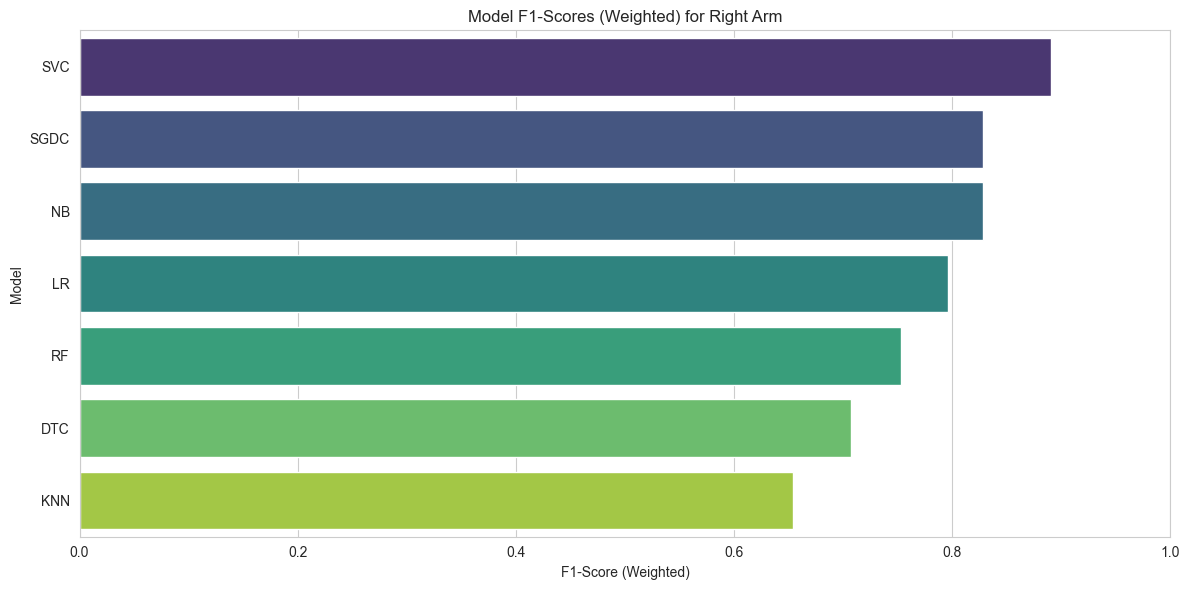

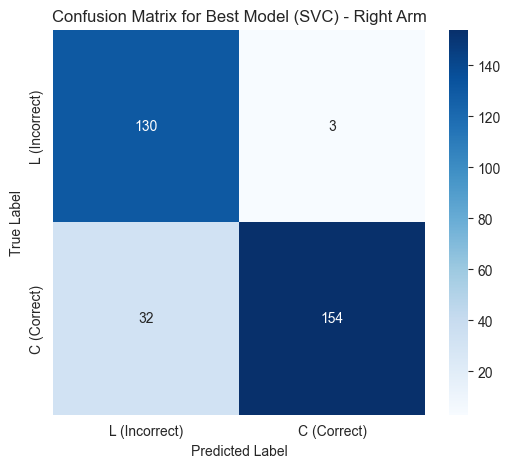

Scaler saved to ../models/pkl/scaler_right.pkl
All trained models dictionary saved to ../models/pkl/all_sklearn_models_right.pkl


Processing complete. Scalers and all_models dictionaries saved in '../models/pkl/' directory if training was successful.


In [35]:
# --- Left Arm ---
scaler_left, all_models_left, results_left_df = None, None, None
if not df_left_train.empty:
    df_test_to_use_left = df_left_test if not df_left_test.empty else pd.DataFrame()
    if df_left_test.empty:
        print("\nWarning: Left arm test data is empty. Training will proceed without test set evaluation for left arm.")
    scaler_left, all_models_left, results_left_df = \
        train_and_evaluate_all_models(df_left_train, df_test_to_use_left, "Left")
    if scaler_left and all_models_left:
         _save_model_artifacts(scaler_left, all_models_left, "Left", MODEL_PKL_DIR)
else:
    print("\nLeft arm training data is empty. Skipping model training and artifact saving for left arm.")

# --- Right Arm ---
scaler_right, all_models_right, results_right_df = None, None, None
if not df_right_train.empty:
    df_test_to_use_right = df_right_test if not df_right_test.empty else pd.DataFrame()
    if df_right_test.empty:
        print("\nWarning: Right arm test data is empty. Training will proceed without test set evaluation for right arm.")
    scaler_right, all_models_right, results_right_df = \
        train_and_evaluate_all_models(df_right_train, df_test_to_use_right, "Right")
    if scaler_right and all_models_right:
        _save_model_artifacts(scaler_right, all_models_right, "Right", MODEL_PKL_DIR)
else:
    print("\nRight arm training data is empty. Skipping model training and artifact saving for right arm.")

print(f"\n\nProcessing complete. Scalers and all_models dictionaries saved in '{MODEL_PKL_DIR}' directory if training was successful.")

## 2.5.1 Choose and Save Specific Models (Optional)

After reviewing the evaluation results in the tables above, you can choose to save a specific model for each arm. This step is optional. The `all_sklearn_models_left.pkl` and `all_sklearn_models_right.pkl` files already contain all trained models. This cell allows you to save a particular model under a more direct name like `RF_model_left.pkl`.

Uncomment and modify the sections below to save your chosen models.

In [38]:
specific_model_left = None
specific_model_left_name = None
specific_model_right = None
specific_model_right_name = None


chosen_left_key = 'NB' 
if all_models_left and chosen_left_key in all_models_left:
    specific_model_left = all_models_left[chosen_left_key]
    specific_model_left_name = chosen_left_key
    save_chosen_model(specific_model_left, specific_model_left_name, "Left", MODEL_PKL_DIR)
elif 'all_models_left' in locals() and all_models_left is not None:
    print(f"Model key '{chosen_left_key}' not found in all_models_left. Available keys: {list(all_models_left.keys())}")
else:
    print("all_models_left is not available. Ensure the previous cell (2.5) was run successfully.")


chosen_right_key = 'NB' 
if all_models_right and chosen_right_key in all_models_right:
    specific_model_right = all_models_right[chosen_right_key]
    specific_model_right_name = chosen_right_key
    save_chosen_model(specific_model_right, specific_model_right_name, "Right", MODEL_PKL_DIR)
elif 'all_models_right' in locals() and all_models_right is not None:
    print(f"Model key '{chosen_right_key}' not found in all_models_right. Available keys: {list(all_models_right.keys())}")
else:
    print("all_models_right is not available. Ensure the previous cell (2.5) was run successfully.")
    

if specific_model_left_name or specific_model_right_name:
    print("\nChosen specific models have been saved (if uncommented and run).")
    print("Variables 'specific_model_left', 'specific_model_left_name', 'specific_model_right', 'specific_model_right_name' are updated.")
else:
    print("\nNo specific models were chosen and saved in this step (code might be commented out).")
    print("You can uncomment the sections above to save specific models if desired.")

Chosen model 'NB' for Left arm saved to ../models/pkl/NB_model_left.pkl
Chosen model 'NB' for Right arm saved to ../models/pkl/NB_model_right.pkl

Chosen specific models have been saved (if uncommented and run).
Variables 'specific_model_left', 'specific_model_left_name', 'specific_model_right', 'specific_model_right_name' are updated.


## 2.6 Summary of Training

In [39]:
print("--- Left Arm Training Summary ---")
if results_left_df is not None and not results_left_df.empty:
    print("Top performing models based on F1-Score (Weighted):")
    display(results_left_df.head(3))
    if specific_model_left and specific_model_left_name:
        print(f"\nSpecifically chosen and saved model for Left Arm: '{specific_model_left_name}' (Type: {type(specific_model_left).__name__})")
    elif 'specific_model_left_name' in locals() and specific_model_left_name is None:
        print("\nNo specific model was chosen to be saved for Left Arm in the dedicated cell.")
    else:
        print("\nSpecific model choice for Left Arm was not processed or 'specific_model_left_name' not defined by choice cell.")
else:
    print("No training results for Left Arm (results_left_df is None or empty).")

print("\n--- Right Arm Training Summary ---")
if results_right_df is not None and not results_right_df.empty:
    print("Top performing models based on F1-Score (Weighted):")
    display(results_right_df.head(3))
    if specific_model_right and specific_model_right_name:
        print(f"\nSpecifically chosen and saved model for Right Arm: '{specific_model_right_name}' (Type: {type(specific_model_right).__name__})")
    elif 'specific_model_right_name' in locals() and specific_model_right_name is None:
        print("\nNo specific model was chosen to be saved for Right Arm in the dedicated cell.")
    else:
        print("\nSpecific model choice for Right Arm was not processed or 'specific_model_right_name' not defined by choice cell.")
else:
    print("No training results for Right Arm (results_right_df is None or empty).")

--- Left Arm Training Summary ---
Top performing models based on F1-Score (Weighted):


,Model,Precision (W),Accuracy,Recall (W),F1-Score (W),Confusion Matrix
5,NB,0.893,0.867,0.867,0.866,"[[131, 1], [37, 116]]"
4,SGDC,0.888,0.853,0.853,0.851,"[[132, 0], [42, 111]]"
0,LR,0.866,0.811,0.811,0.806,"[[132, 0], [54, 99]]"



Specifically chosen and saved model for Left Arm: 'NB' (Type: GaussianNB)

--- Right Arm Training Summary ---
Top performing models based on F1-Score (Weighted):


,Model,Precision (W),Accuracy,Recall (W),F1-Score (W),Confusion Matrix
1,SVC,0.907,0.890,0.890,0.891,"[[130, 3], [32, 154]]"
4,SGDC,0.868,0.828,0.828,0.828,"[[130, 3], [52, 134]]"
5,NB,0.868,0.828,0.828,0.828,"[[130, 3], [52, 134]]"



Specifically chosen and saved model for Right Arm: 'NB' (Type: GaussianNB)
